# Welcome to this Kernel

## *** This kernel is a compilation of tricks of sklearn published by Kevin Markham weekly.***

You can find the original tricks and tips on the GitHub repo:

https://github.com/justmarkham/scikit-learn-tips


## *** This kernel is under construction. I will be updating it regularly.***

<a id = "table_of_contents"></a>
# Table of contents

[Importing libraries and setting some helper functions](#Imports)

[Trick 35: Passing a df directly to sklearn](#trick35)

[Trick 34: Feature selection with Pipeline](#trick34)

[Trick 33: Using custom and existing function in a ColumnTransformer](#trick33)

[Trick 32: Area Under Curve (AUC) for binary classification: ovo and ovr strategies](#trick32)

[Trick 31: Shuffle when using cross_val_score](#trick31)

[Trick 30: Four ways of displaying the model coefficients](#trick30)

[Trick 29: Vectorize two text columns using ColumnTransformer](#trick29)

[Trick 28: Save a model of pipeline using joblib](#trick28)

[Trick 27: Imputing missing values for categorical values](#trick27)

[Trick 26: Use of stratify when performing classification problems](#trick26)

[Trick 25: Prunning decision trees (new in 0.22 and above).](#trick25)

[Trick 24: Plotting the decision tree with sklearn (new in 0.21 and above)](#trick24)

[Trick 23: Display the intercept & coefficients for a liner model](#trick23)

[Trick 22: Two types of Pipelines](#trick22)

[Trick 21: Several ROC curves in a single plot (new in sklearn 0.22)](#trick21)

[Trick 20: Plot confusion matrix (new in sklearn 0.22)](#trick20)

[Trick 19: Most important parameters of a LogisticRegression](#trick19)

[Trick 18: Convert your GridSearchCV or RandomizedGridSearch results into a pandas DataFrame](#trick18)

[Trick 17: RandomizedGridSearch](#trick17)

[Trick 16: Crossvalidate and gridsearch a sklearn pipeline](#trick16)

[Trick 15: OneHotEncoder: tips using it](#trick15)

[Trick 14: Handling missing values](#trick14)

[Trick 13: Examine each step of a Pipeline](#trick13)

[Trick 12: Difference between Pipeline and make_pipeline](#trick12)

[Trick 11: KNNImputer](#trick11)

[Trick 10: Using random_state to reproduce results](#trick10)

[Trick 9: Using missing values as a feature: SimpleImputer & add_indicator = True](#trick9)

[Trick 8: Using make_pipeline in a ML project](#trick8)

[Trick 7: Handle new data while using OneHotEncoder](#trick7)

[Trick 6: Common ways to encode categorical features: OneHotEncoder, OrdinalEncoder](#trick6)

[Trick 5: Benefits of using sklearn for preprocessing and not pandas](#trick5)

[Trick 4: When to use fit_transform and transform methods](#trick4)

[Trick 3: Difference between fit and transform method](#trick3)

[Trick 2: Seven ways to select columns using ColumnsTransformer](#trick2)

[Trick 1: Using column selector to transform different columns](#trick1)


<a id = "Imports"></a>
# Importing libraries and setting some helper functions
[Go back to the Table of Contents](#table_of_contents)

In [1]:
# basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

# this will allow us to print all the files as we generate more in the kernel
def print_files(directory = "output"):
    if directory.lower() == "input":
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
    else:
        for dirname, _, filenames in os.walk('/kaggle/working'):
            for filename in filenames:
                print(os.path.join(dirname, filename))

# check Trick 91 for an example
def generate_sample_data(): # creates a fake df for testing
    number_or_rows = 20
    num_cols = 7
    cols = list("ABCDEFG")
    df = pd.DataFrame(np.random.randint(1, 20, size = (number_or_rows, num_cols)), columns=cols)
    df.index = pd.util.testing.makeIntIndex(number_or_rows)
    return df

# check Trick 91 for an example
def generate_sample_data_datetime(): # creates a fake df for testing
    number_or_rows = 365*24
    num_cols = 2
    cols = ["sales", "customers"]
    df = pd.DataFrame(np.random.randint(1, 20, size = (number_or_rows, num_cols)), columns=cols)
    df.index = pd.util.testing.makeDateIndex(number_or_rows, freq="H")
    return df

# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print_files("input")

/kaggle/input/logisticregression/LogisticRegression.jpg
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/roc-curve/ROC Curve.jpeg


<a id = "trick35"></a>
# Trick 35: Passing a df directly to sklearn
[Go back to the Table of Contents](#table_of_contents)

In [2]:
# We don't need to use .values when passing a df or a pandas series to sklearn
# It knows internally how to acess the values and deal with them

#------------------------------------------------------------
# import libraries
from sklearn.linear_model import LogisticRegression

#------------------------------------------------------------
# get the data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df[['Pclass', 'Fare']]
y = df["Survived"]

#------------------------------------------------------------
# check the X and y types
print(type(X))
print(type(y))

#------------------------------------------------------------
# instanciate our classes
model = LogisticRegression()

# we fit directly a df and a series and sklearn deals with the rest
model.fit(X, y)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<a id = "trick34"></a>
# Trick 34: Feature selection with Pipeline
[Go back to the Table of Contents](#table_of_contents)

In [3]:
#------------------------------------------------------------
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile, chi2

#------------------------------------------------------------
# get the data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df["Name"]
y = df["Survived"]

#------------------------------------------------------------
# instanciate our classes
vectorizer = CountVectorizer()
model = LogisticRegression()

#------------------------------------------------------------
# make the pipeline without feature selection
pipe = make_pipeline(vectorizer, model)
score = cross_val_score(pipe, X, y, scoring = 'accuracy').mean()
print("Score of pipeline without feature selection is {}".format(score))

#------------------------------------------------------------
# make the pipeline without feature selection

# keep 50% of features with the best chi-squared scores
selection = SelectPercentile(chi2, percentile = 50)

# add the selection after preprocessing but before model
pipe = make_pipeline(vectorizer, selection, model)
score = cross_val_score(pipe, X, y, scoring = 'accuracy').mean()
print("Score of pipeline with feature selection is {}".format(score))

Score of pipeline without feature selection is 0.7957190383528967
Score of pipeline with feature selection is 0.8147824995292197


<a id = "trick33"></a>
# Trick 33: Using custom and existing function in a ColumnTransformer
[Go back to the Table of Contents](#table_of_contents)

In [4]:
#------------------------------------------------------------
# import libraries
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

#------------------------------------------------------------
# get some data
X = pd.DataFrame({'Fare':[200, 300, 50, 900],
                  'Code':['X12', 'Y20', 'Z7', np.nan],
                  'Deck':['A101', 'C102', 'A200', 'C300']})

#------------------------------------------------------------
# use an existing column and make the function compatible with Pipeline
clip_values = FunctionTransformer(np.clip, kw_args={'a_min':100, 'a_max':600})

#------------------------------------------------------------
# create a custom function
def first_letter(string_column):
    return string_column.apply(lambda x: x.str.slice(0, 1))

# now use FunctionTransformer to make the function compatible with Pipeline
get_first_letter = FunctionTransformer(first_letter)

#------------------------------------------------------------
# create the column Transformer
ct = make_column_transformer(
    (clip_values, ['Fare']),
    (get_first_letter, ['Code', 'Deck']))

#------------------------------------------------------------
# Original X
print("Original X")
X

#------------------------------------------------------------
# Modified X
print("Modified X")
ct.fit_transform(X)

Original X


,Fare,Code,Deck
0,200,X12,A101
1,300,Y20,C102
2,50,Z7,A200
3,900,NaN,C300


Modified X


array([[200, 'X', 'A'],
       [300, 'Y', 'C'],
       [100, 'Z', 'A'],
       [600, nan, 'C']], dtype=object)

<a id = "trick32"></a>
# Trick 32: Area Under Curve (AUC) for binary classification: ovo and ovr strategies
[Go back to the Table of Contents](#table_of_contents)

In [5]:
#------------------------------------------------------------
# import libraries
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# get X and y for classification
X, y = load_wine(return_X_y=True)

# select only a few features
X = X[:, 0:2]

# instanciate the model for regression
model_clf = LogisticRegression()

# Multiclass AUC with train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model_clf.fit(X_train, y_train)
y_score = model_clf.predict_proba(X_test)

# use 'ovo' (One-vs-One) or 'ovr' (One-vs-Rest)
print("roc_auc_score is {} for one vs one strategy with train test split".format(roc_auc_score(y_test, y_score, multi_class = 'ovo')))
print("roc_auc_score is {} for one vs rest strategy with train test split".format(roc_auc_score(y_test, y_score, multi_class = 'ovr')))
print("-----------------------------------------")

# Multiclass AUC with cross-validation
# use 'roc_auc_ovo' (One-vs-One) or 'roc_auc_ovr' (One-vs-Rest)
print("cross_val_score is {} for one vs one strategy with cross validation".format(cross_val_score(model_clf, X, y, cv = 5, scoring = 'roc_auc_ovo').mean()))
print("cross_val_score is {} for one vs rest strategy with cross validation".format(cross_val_score(model_clf, X, y, cv = 5, scoring = 'roc_auc_ovr').mean()));

roc_auc_score is 0.9399801587301587 for one vs one strategy with train test split
roc_auc_score is 0.9484053018535777 for one vs rest strategy with train test split
-----------------------------------------
cross_val_score is 0.9086960878627546 for one vs one strategy with cross validation
cross_val_score is 0.9123529143963927 for one vs rest strategy with cross validation


<a id = "trick31"></a>
# Trick 31: Shuffle when using cross_val_score
[Go back to the Table of Contents](#table_of_contents)

In [6]:
#------------------------------------------------------------
# import libraries
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

# get X and y for regression
X_reg, y_reg = load_diabetes(return_X_y = True)

# get X and y for classification
df = pd.read_csv("/kaggle/input/titanic/train.csv", usecols = ['Pclass', 'Fare', 'SibSp', 'Survived']).dropna()

# separate X and y
X_clf = df[['Pclass', 'Fare', 'SibSp']]
y_clf = df[["Survived"]]

# instanciate the model for regression
model_reg = LinearRegression()

# instanciate the model for classification
model_clf = LogisticRegression()

# Use KFold for regression
kf = KFold(5, shuffle = True, random_state = 1)
print("cross_val_score for regression model")
cross_val_score(model_reg, # the regression model, in our case, LinearRegression
                X_reg, # X: features to learn from
                y_reg, # y: what the predict
                cv = kf, # cross_validation scheme we have created earlier
                scoring = "r2") # metric to use to validate the quality of the model

# Use StratifiedKFold for classification
skf = StratifiedKFold(5, shuffle = True, random_state = 1)
print("cross_val_score for classification model")
cross_val_score(model_clf, # the model, in our case, LogisticRegression
                X_clf, # X: features to learn from
                y_clf, # y: what the predict
                cv = skf, # cross_validation scheme we have created earlier
                scoring = "accuracy") # metric to use to validate the quality of the model

cross_val_score for regression model


array([0.43843604, 0.38982527, 0.52792606, 0.47359858, 0.57449343])

cross_val_score for classification model


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

array([0.65363128, 0.7247191 , 0.66853933, 0.68539326, 0.65730337])

<a id = "trick30"></a>
# Trick 30: Four ways of displaying the model coefficients
[Go back to the Table of Contents](#table_of_contents)

In [7]:
#------------------------------------------------------------
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#------------------------------------------------------------
# instanciate the classes
ohe = OneHotEncoder()
model = LogisticRegression()

#------------------------------------------------------------
# get the data
df = pd.read_csv("/kaggle/input/titanic/train.csv", usecols = ['Embarked', 'Survived']).dropna()

# separate X and y
X = df[["Embarked"]]
y = df[["Survived"]]

# create a pipeline and fit the X and y
pipe = Pipeline([("ohe", ohe),
                 ("clf", model)])
pipe.fit(X, y)

# inspect the coefficients
print("1 way to show model coefficients")
pipe.named_steps.clf.coef_
print("2 way to show model coefficients")
pipe.named_steps["clf"].coef_
print("3 way to show model coefficients")
pipe["clf"].coef_
print("4 way to show model coefficients")
pipe[1].coef_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

1 way to show model coefficients


array([[ 0.5072001 , -0.13716737, -0.37001877]])

2 way to show model coefficients


array([[ 0.5072001 , -0.13716737, -0.37001877]])

3 way to show model coefficients


array([[ 0.5072001 , -0.13716737, -0.37001877]])

4 way to show model coefficients


array([[ 0.5072001 , -0.13716737, -0.37001877]])

<a id = "trick29"></a>
# Trick 29: Vectorize two text columns using ColumnTransformer
[Go back to the Table of Contents](#table_of_contents)

In [8]:
#------------------------------------------------------------
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

#------------------------------------------------------------
# get train data
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")

# drop any nans
X = df_train[["Name", "Cabin"]].dropna()

#------------------------------------------------------------
# instanciate CountVectorizer
count_vect = CountVectorizer()

#------------------------------------------------------------
# instanciate CountVectorizer
# You can pass the CountVectorizer multiple times and it will learn
# separate vocabularies.
# to do so, you must use make_column_transformer
ct = make_column_transformer((count_vect, 'Name'), (count_vect, 'Cabin'))
X_transform = ct.fit_transform(X)
X_transform

<204x637 sparse matrix of type '<class 'numpy.longlong'>'
	with 1119 stored elements in Compressed Sparse Row format>

<a id = "trick28"></a>
# Trick 28: Save a model of pipeline using joblib
[Go back to the Table of Contents](#table_of_contents)

In [9]:
#------------------------------------------------------------
# import libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import joblib

#------------------------------------------------------------
# get train data
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")

# drop any nans
df_train.dropna(axis = "rows", inplace = True)

# separate X and y
cols_for_x = ["Embarked", "Sex"]
X_train = df_train[cols_for_x]
y_train = df_train["Survived"]

#------------------------------------------------------------
# get test data
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

# drop any nans
df_test.dropna(axis = "rows", inplace = True)

X_test = df_test[cols_for_x]

#------------------------------------------------------------
# instanciate Ohe and make_pipeline
ohe = OneHotEncoder()
model = LogisticRegression()

#------------------------------------------------------------
# create the pipeline
pipe = make_pipeline(ohe, model)

#------------------------------------------------------------
# predict_using pipeline
pipe.fit(X_train, y_train)

#------------------------------------------------------------
# save pipeline
joblib.dump(pipe, 'pipe.joblib')

# print our newly saved pipeline
print_files()

#------------------------------------------------------------
# save pipeline
new_pipe = joblib.load('/kaggle/working/pipe.joblib')

#------------------------------------------------------------
# predict using the same pipe and the old pipe
print("------------")
print("Old pipe.")
pipe.predict(X_test)
print("------------")
print("Old pipe.")
new_pipe.predict(X_test)
print("Notice that both pipes predict the same result.")

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

['pipe.joblib']

/kaggle/working/pipe.joblib
/kaggle/working/__notebook__.ipynb
------------
Old pipe.


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

------------
Old pipe.


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Notice that both pipes predict the same result.


<a id = "trick27"></a>
# Trick 27: Imputing missing values for categorical values
[Go back to the Table of Contents](#table_of_contents)

In [10]:
#------------------------------------------------------------
# get some fake data
d = {"Shape_Original":["square", "square", "square", "oval", "circle", np.nan]}
df = pd.DataFrame(d)

#------------------------------------------------------------
# import libraries
from sklearn.impute import SimpleImputer

#------------------------------------------------------------
# impute values using most frequent
df["most_frequent"] = SimpleImputer(strategy = "most_frequent").fit_transform(df[["Shape_Original"]])

#------------------------------------------------------------
# impute values using most constant
df["constant"]  = SimpleImputer(strategy = "constant", fill_value = "missing").fit_transform(df[["Shape_Original"]])

#------------------------------------------------------------
# the result of our imputation
df.style.apply(lambda x: ['background: lightgreen' if x.name == 5 else '' for i in x], axis=1)

,Shape_Original,most_frequent,constant
0,square,square,square
1,square,square,square
2,square,square,square
3,oval,oval,oval
4,circle,circle,circle
5,nan,square,missing


<a id = "trick26"></a>
# Trick 26: Use of stratify when performing classification problems
[Go back to the Table of Contents](#table_of_contents)

In [11]:
#------------------------------------------------------------
# import libraries
from sklearn.model_selection import train_test_split

#------------------------------------------------------------
# generate some data and separate X and y
df = pd.DataFrame({'feature':list(range(8)), 'target':['not fraud']*6 + ['fraud']*2})
X = df[['feature']]
y = df['target']

#------------------------------------------------------------
# train and test without stratify

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)

print("y_train withous stratify")
y_train
print("y_test withous stratify")
y_test


#------------------------------------------------------------
# train and test with stratify

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 1)

print("Notice how using statify preserves the fraud and not fraud percentage.")
print("y_train with stratify")
y_train
print("y_test with stratify")
y_test

y_train withous stratify


0    not fraud
4    not fraud
3    not fraud
5    not fraud
Name: target, dtype: object

y_test withous stratify


7        fraud
2    not fraud
1    not fraud
6        fraud
Name: target, dtype: object

Notice how using statify preserves the fraud and not fraud percentage.
y_train with stratify


1    not fraud
2    not fraud
6        fraud
5    not fraud
Name: target, dtype: object

y_test with stratify


4    not fraud
3    not fraud
7        fraud
0    not fraud
Name: target, dtype: object

<a id = "trick25"></a>
# Trick 25: Prunning decision trees (new in 0.22 and above).
[Go back to the Table of Contents](#table_of_contents)

In [12]:
import sklearn
print(sklearn.__version__)

#------------------------------------------------------------
# import libraries
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df['Sex'] = df['Sex'].map({'male':0, 'female':1})
X = df[["Pclass", "Fare", "Sex"]]
y = df["Survived"]

#------------------------------------------------------------
# basic model and evaluation
model = DecisionTreeClassifier(random_state = 175)
model.fit(X, y)
score = cross_val_score(model, X, y, scoring = "accuracy")
print("Our DecissionTree with {} nodes has scored {}".format(model.tree_.node_count, score.mean()))

#------------------------------------------------------------
# prun the tree and see cross validation score
# Notice that the score went up. Prunnig trees has a lot of benefits, the main one is reducing overfitting.
# ccp_alpha is the parameter that controls the decision tree complexity (cost complexity parameter).
# Greater values of ccp_alpha increase the number of nodes pruned.
# documentation 
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

model = DecisionTreeClassifier(ccp_alpha = 0.001, random_state = 175)
model.fit(X, y)
score = cross_val_score(model, X, y, scoring = "accuracy")
print("Our prunned DecissionTree with {} nodes has scored {}".format(model.tree_.node_count, score.mean()))

0.22.2.post1


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=175, splitter='best')

Our DecissionTree with 311 nodes has scored 0.8126294645659407


DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=175, splitter='best')

Our prunned DecissionTree with 113 nodes has scored 0.8148578243675851


<a id = "trick24"></a>
# Trick 24: Plotting the decision tree with sklearn (new in 0.21 and above).
[Go back to the Table of Contents](#table_of_contents)

0.22.2.post1


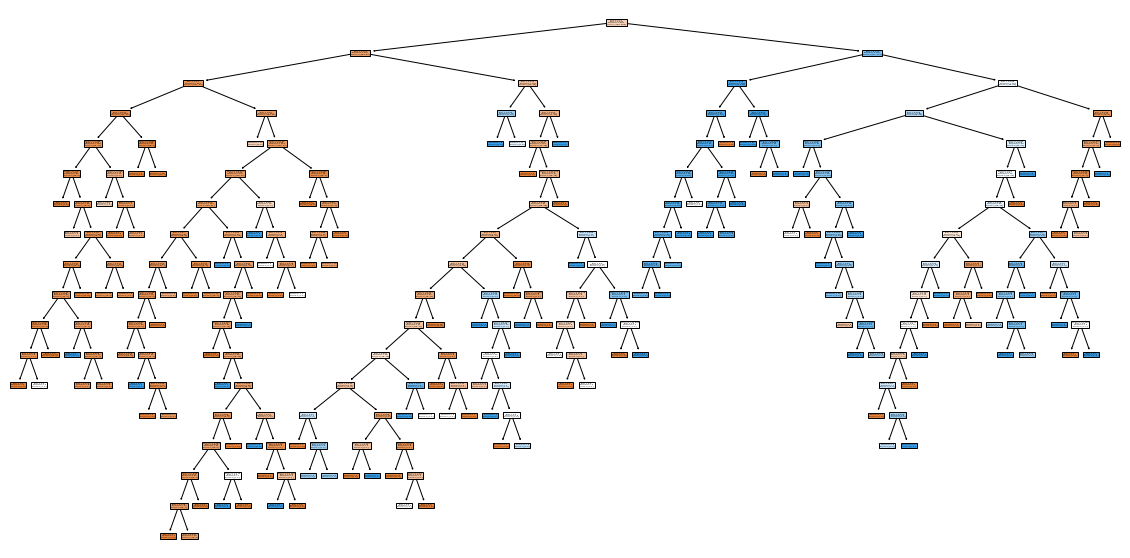

In [13]:
import sklearn
print(sklearn.__version__)

#------------------------------------------------------------
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

#------------------------------------------------------------
# create our instances
model = DecisionTreeClassifier()

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df['Sex'] = df['Sex'].map({'male':0, 'female':1})
X = df[["Pclass", "Fare", "Sex"]]
y = df["Survived"]

features = ["Pclass", "Fare", "Sex"]
classes = ["Survived"]

#------------------------------------------------------------
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#------------------------------------------------------------
# fit and predict

model.fit(X_train, y_train)

#------------------------------------------------------------
# plot the tree

plt.figure(figsize = (20, 10))
plot_tree(model, feature_names = features, filled = True);

In [14]:
#------------------------------------------------------------
# show the text
# I will plot only the first 200 characters of the tree since it grows rapidly
print(export_text(model, feature_names = features, show_weights=True)[:200]);

|--- Sex <= 0.50
|   |--- Fare <= 26.27
|   |   |--- Fare <= 7.91
|   |   |   |--- Fare <= 7.86
|   |   |   |   |--- Fare <= 7.79
|   |   |   |   |   |--- Pclass <= 2.50
|   |   |   |   |   |   |--- w


<a id = "trick23"></a>
# Trick 23: Display the intercept & coefficients for a liner model
[Go back to the Table of Contents](#table_of_contents)

In [15]:
#------------------------------------------------------------
# import libraries
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

#------------------------------------------------------------
# load data and separate X and y
dataset = load_diabetes()
X, y = dataset.data, dataset.target
features = dataset.feature_names

#------------------------------------------------------------
# fit model
model = LinearRegression()
model.fit(X, y)

#------------------------------------------------------------
# intercept and coef
model.intercept_
model.coef_
list(zip(features, model.coef_))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

152.1334841628965

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

[('age', -10.012197817470847),
 ('sex', -239.81908936565472),
 ('bmi', 519.8397867901343),
 ('bp', 324.3904276893763),
 ('s1', -792.1841616283061),
 ('s2', 476.74583782366255),
 ('s3', 101.04457032134488),
 ('s4', 177.0641762322512),
 ('s5', 751.2793210873945),
 ('s6', 67.62538639104386)]

<a id = "trick22"></a>
# Trick 22: Two types of Pipelines
[Go back to the Table of Contents](#table_of_contents)

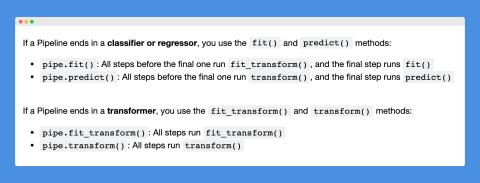

In [16]:
#------------------------------------------------------------
# Two types of ROC Curve

# If the pipeline ends in a classifier or regressor, you use the fit and predict methods
# If the pipeline ends in a transformer you use the fit_transform and transform methods

path = "/kaggle/input/roc-curve/ROC Curve.jpeg"
Image(path)

<a id = "trick21"></a>
# Trick 21: Several ROC curves in a single plot (new in sklearn 0.22)
[Go back to the Table of Contents](#table_of_contents)

0.22.2.post1


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

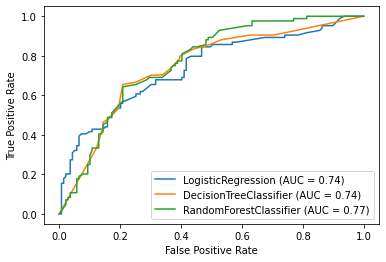

In [17]:
import sklearn
print(sklearn.__version__)

#------------------------------------------------------------
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#------------------------------------------------------------
# create our instances
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df[["Pclass", "Fare"]]
y = df["Survived"]

#------------------------------------------------------------
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#------------------------------------------------------------
# fit and predict
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

#------------------------------------------------------------
# plot roc curve
disp = plot_roc_curve(lr, X_test, y_test)
plot_roc_curve(dt, X_test, y_test, ax = disp.ax_) # ax = disp.ax_ this line will share the x axis
plot_roc_curve(rf, X_test, y_test, ax = disp.ax_)

<a id = "trick20"></a>
# Trick 20: Plot confusion matrix (new in sklearn 0.22)
[Go back to the Table of Contents](#table_of_contents)

0.22.2.post1


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The classical confusion matrix


array([[122,  17],
       [ 48,  36]])

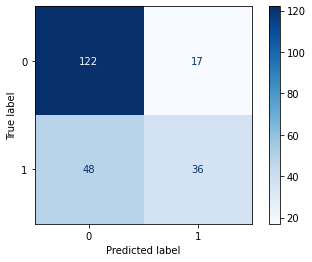

In [18]:
import sklearn
print(sklearn.__version__)

#------------------------------------------------------------
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

#------------------------------------------------------------
# create our instances
model = LogisticRegression(random_state = 1)

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df[["Pclass", "Fare"]]
y = df["Survived"]

#------------------------------------------------------------
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#------------------------------------------------------------
# fit and predict

model.fit(X_train, y_train)

#------------------------------------------------------------
# plot confusion matrix
# notice that you have to pass the model, X_test and y_test
# plot_confusion_matrix predicts with the model and plots the values

disp = plot_confusion_matrix(model, X_test, y_test, cmap = "Blues", values_format = ".3g")

print("The classical confusion matrix")
disp.confusion_matrix

<a id = "trick19"></a>
# Trick 19: Most important parameters of a LogisticRegression
[Go back to the Table of Contents](#table_of_contents)

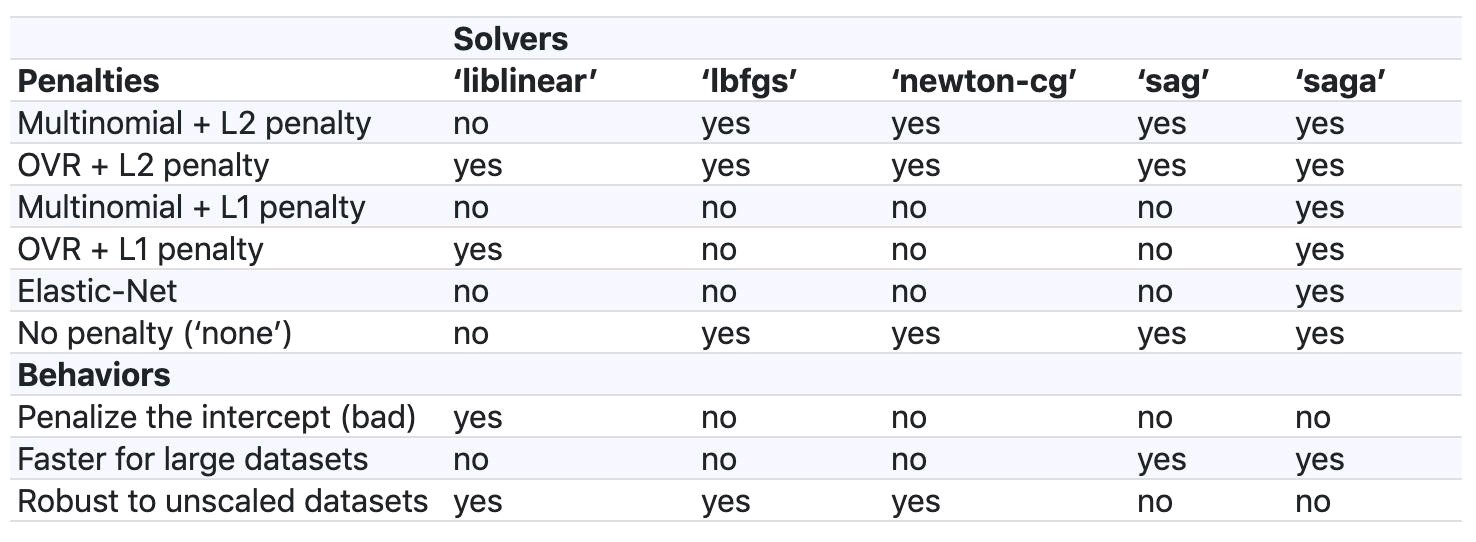

In [19]:
#------------------------------------------------------------
# C: inverse of regularization strength
# penalty: type of regularization
# solver: algorithm used for optimization

path = "/kaggle/input/logisticregression/LogisticRegression.jpg"
Image(path)

<a id = "trick18"></a>
# Trick 18: Convert your GridSearchCV or RandomizedGridSearch results into a pandas DataFrame
[Go back to the Table of Contents](#table_of_contents)

In [20]:
#------------------------------------------------------------
# import libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

#------------------------------------------------------------
# create our instances
ohe = OneHotEncoder()
vect = CountVectorizer()
ct = make_column_transformer((ohe, ["Sex"]), (vect, "Name"))
model = LogisticRegression(solver = "liblinear", random_state = 1)

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df[["Sex", "Name", "Fare"]]
y = df["Survived"]

#------------------------------------------------------------
# make pipeline
pipeline = make_pipeline(ct, model)

#------------------------------------------------------------
# cross validate the entire pipeline
print("Notice the score of our entire pipeline is {}".format(cross_val_score(pipeline, X, y, cv = 5, scoring = "accuracy").mean()))
cross_val_score(pipeline, X, y, cv = 5, scoring = "accuracy").mean()

#------------------------------------------------------------
# gridsearch the entire pipeline

# set the parameters
params = {"columntransformer__countvectorizer__min_df":[1, 2],
         "logisticregression__C":[0.1, 1, 10],
         "logisticregression__penalty":["l1", "l2"]}

grid = GridSearchCV(pipeline, params, cv = 5, scoring = "accuracy")
grid.fit(X, y)

# convert to a pandas DataFrame

results = pd.DataFrame(grid.cv_results_)[["params", "mean_test_score", "rank_test_score"]]
results.sort_values("rank_test_score")

Notice the score of our entire pipeline is 0.8024543343167408


0.8024543343167408

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='error',
                        

,params,mean_test_score,rank_test_score
4,{'columntransformer__countvectorizer__min_df':...,0.821518,1
2,{'columntransformer__countvectorizer__min_df':...,0.820400,2
8,{'columntransformer__countvectorizer__min_df':...,0.820400,2
5,{'columntransformer__countvectorizer__min_df':...,0.814795,4
11,{'columntransformer__countvectorizer__min_df':...,0.812523,5
9,{'columntransformer__countvectorizer__min_df':...,0.810313,6
3,{'columntransformer__countvectorizer__min_df':...,0.802454,7
10,{'columntransformer__countvectorizer__min_df':...,0.797916,8
0,{'columntransformer__countvectorizer__min_df':...,0.786737,9
1,{'columntransformer__countvectorizer__min_df':...,0.786737,9


<a id = "trick17"></a>
# Trick 17: RandomizedGridSearch
[Go back to the Table of Contents](#table_of_contents)

In [21]:
#------------------------------------------------------------
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
import scipy as sp

#------------------------------------------------------------
# create our instances
vect = CountVectorizer()
model = MultinomialNB()

#------------------------------------------------------------
# make pipeline
pipeline = make_pipeline(vect, model)

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df['Name']
y = df['Survived']

#------------------------------------------------------------
# set the params to optimize

params = {}

params["countvectorizer__min_df"] = [1, 2, 3, 4]
params["countvectorizer__lowercase"] = [True, False]
params["multinomialnb__alpha"] = sp.stats.uniform(scale = 1)

#------------------------------------------------------------
# optimize

rand = RandomizedSearchCV(pipeline, params, n_iter = 10, cv = 5, scoring = "accuracy", random_state = 1)
rand.fit(X, y)

#------------------------------------------------------------
# best score and params

print("Best score achieved with our search is:")
rand.best_score_

print("Best params are:")
rand.best_params_

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('countvectorizer',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                               

Best score achieved with our search is:


0.8080534806352395

Best params are:


{'countvectorizer__lowercase': False,
 'countvectorizer__min_df': 3,
 'multinomialnb__alpha': 0.1981014890848788}

<a id = "trick16"></a>
# Trick 16: Crossvalidate and gridsearch a sklearn pipeline
[Go back to the Table of Contents](#table_of_contents)

In [22]:
#------------------------------------------------------------
# import libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

#------------------------------------------------------------
# create our instances
ohe = OneHotEncoder()
vect = CountVectorizer()
ct = make_column_transformer((ohe, ["Sex"]), (vect, "Name"))
model = LogisticRegression(solver = "liblinear", random_state = 1)

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
X = df[["Sex", "Name", "Fare"]]
y = df["Survived"]

#------------------------------------------------------------
# make pipeline
pipeline = make_pipeline(ct, model)

#------------------------------------------------------------
# cross validate the entire pipeline
print("Notice the score of our entire pipeline is {}".format(cross_val_score(pipeline, X, y, cv = 5, scoring = "accuracy").mean()))
cross_val_score(pipeline, X, y, cv = 5, scoring = "accuracy").mean()

#------------------------------------------------------------
# gridsearch the entire pipeline

# set the parameters
params = {"columntransformer__countvectorizer__min_df":[1, 2],
         "logisticregression__C":[0.1, 1, 10],
         "logisticregression__penalty":["l1", "l2"]}

grid = GridSearchCV(pipeline, params, cv = 5, scoring = "accuracy")
grid.fit(X, y)

# see the best score
print("#-------------------------------------------------------------------------")
print("Best score of the GridSearchCV is ")
grid.best_score_

# see the best params
print("#-------------------------------------------------------------------------")
print("Best parameters of the GridSearchCV are ")
grid.best_params_

Notice the score of our entire pipeline is 0.8024543343167408


0.8024543343167408

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='error',
                        

#-------------------------------------------------------------------------
Best score of the GridSearchCV is 


0.8215177954930638

#-------------------------------------------------------------------------
Best parameters of the GridSearchCV are 


{'columntransformer__countvectorizer__min_df': 1,
 'logisticregression__C': 10,
 'logisticregression__penalty': 'l1'}

<a id = "trick15"></a>
# Trick 15: OneHotEncoder: tips using it
[Go back to the Table of Contents](#table_of_contents)

If you use OneHotEncoder, don't "drop = 'first'":
1. Multicollinearity is rarely and issue with sklearn models
2. drop = 'first' is incompatible with handle_unknown = 'ignore'
3. May cause you problems if yoy standarize all features or use a regularized model

<a id = "trick14"></a>
# Trick 14: Handling missing values
[Go back to the Table of Contents](#table_of_contents)

In [23]:
#------------------------------------------------------------
# If you have missing values you can:
# 1. Drop all rows with missing values
# 2. Drop all colmns with missing values
# 3. Impute missing values
# 4. Use a model that handles missing values

#------------------------------------------------------------
# import libraries
from sklearn.experimental import enable_hist_gradient_boosting # this import enables "experimental" packages and clases in sklearn
from sklearn.ensemble import HistGradientBoostingClassifier # this is an experimental package
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
print("We can see that we have missing values")

df.isnull().sum()

#------------------------------------------------------------
# split target and feature

features = [col for col in df.columns if df[col].dtype != "object"] # select only numerical columns
features.remove("Survived")
features.remove("PassengerId")

X = df[features]
y = df["Survived"]

#------------------------------------------------------------
# Train a model that handles missing values

model = HistGradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 175)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy of our model while having missing values is {}%".format(round(accuracy_score(y_test, y_pred), 2)*100))


We can see that we have missing values


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

Accuracy of our model while having missing values is 64.0%


<a id = "trick13"></a>
# Trick 13: Examine each step of a Pipeline
[Go back to the Table of Contents](#table_of_contents)

In [24]:
#------------------------------------------------------------
# import libraries
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#------------------------------------------------------------
# create each instance
si = SimpleImputer()
model = LogisticRegression()

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")

#------------------------------------------------------------
# select columns to transform
X = df[["Fare", "Age"]].head()
X["Age"].iloc[0] = np.nan # create a missing values
X.head()

y = df[["Survived"]].head()

#------------------------------------------------------------
# use make_pipeline

pipeline = make_pipeline(si, model)

pipeline.fit(X, y)

#------------------------------------------------------------
# let's see the statistics of each step
print("These are the imputed values with the SimpleImputer")
pipeline.named_steps.simpleimputer.statistics_

print("Display the coefficients of the linear model")
pipeline.named_steps.logisticregression.coef_

,Fare,Age
0,7.2500,NaN
1,71.2833,38.0
2,7.9250,26.0
3,53.1000,35.0
4,8.0500,35.0


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

These are the imputed values with the SimpleImputer


array([29.52166, 33.5    ])

Display the coefficients of the linear model


array([[ 0.20785238, -0.66529709]])

<a id = "trick12"></a>
# Trick 12: Difference between Pipeline and make_pipeline
[Go back to the Table of Contents](#table_of_contents)

In [25]:
#------------------------------------------------------------
# import libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

#------------------------------------------------------------
# create each instance
ohe = OneHotEncoder()
si = SimpleImputer()
model = LogisticRegression()

#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")

#------------------------------------------------------------
# select columns to transform
X = df[["Fare", "Embarked", "Sex", "Age"]].head()
X["Age"].iloc[0] = np.nan # create a missing values
X.head()

y = df[["Survived"]].head()

#------------------------------------------------------------
# use make_pipeline

column_transformer = make_column_transformer(
(ohe, ["Embarked", "Sex"]),
(si, ["Age"]),
remainder = "passthrough"
)

pipeline = make_pipeline(column_transformer, model)

pipeline.fit(X, y)

#------------------------------------------------------------
# use Pipeline
# The main difference is that we must name each step

column_transformer = ColumnTransformer(
[("encoder", ohe, ["Embarked", "Sex"]), # notice how we must name each step
("imputer", si, ["Age"])],
remainder = "passthrough"
)

pipeline = Pipeline([("preprocessing", column_transformer), ("model", model)]) # notice how we must name each step
pipeline.fit(X, y)

,Fare,Embarked,Sex,Age
0,7.2500,S,male,NaN
1,71.2833,C,female,38.0
2,7.9250,S,female,26.0
3,53.1000,S,female,35.0
4,8.0500,S,male,35.0


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Embarked', 'Sex']),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicato...
                                            

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('encoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Embarked', 'Sex']),
                                                 ('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                       

<a id = "trick11"></a>
# Trick 11: KNNImputer
[Go back to the Table of Contents](#table_of_contents)

In [26]:
#------------------------------------------------------------
# import libraries
from sklearn.impute import KNNImputer

#------------------------------------------------------------
# create some random data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.isnull().sum() # inspect nulls
df.head()

#------------------------------------------------------------
# let's see KNNInputer in action
knn_inputer = KNNImputer()

X = df[["SibSp", "Fare", "Age"]]
nan_index = X[X["Age"].isnull()].index

print("Data with nans")
X[X.index.isin(nan_index)].head(10)

print("Transformed data with no nans, and the values are based on the NN.")
X_transformed = pd.DataFrame(knn_inputer.fit_transform(X), columns = ["SibSp", "Fare", "Age"], index = X.index)
X_transformed[X.index.isin(nan_index)].head(10)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data with nans


,SibSp,Fare,Age
5,0,8.4583,NaN
17,0,13.0000,NaN
19,0,7.2250,NaN
26,0,7.2250,NaN
28,0,7.8792,NaN
29,0,7.8958,NaN
31,1,146.5208,NaN
32,0,7.7500,NaN
36,0,7.2292,NaN
42,0,7.8958,NaN


Transformed data with no nans, and the values are based on the NN.


,SibSp,Fare,Age
5,0.0,8.4583,22.684
17,0.0,13.0000,24.600
19,0.0,7.2250,26.400
26,0.0,7.2250,26.400
28,0.0,7.8792,29.400
29,0.0,7.8958,28.600
31,1.0,146.5208,21.584
32,0.0,7.7500,40.700
36,0.0,7.2292,23.000
42,0.0,7.8958,28.600


<a id = "trick10"></a>
# Trick 10: Using random_state to reproduce results
[Go back to the Table of Contents](#table_of_contents)

In [27]:
#------------------------------------------------------------
# import libraries
from sklearn.model_selection import train_test_split

#------------------------------------------------------------
# create some random data

df = generate_sample_data()
target = [np.random.choice([0, 1]) for i in range(len(df))]
df["target"] = target
print("A sneak peak at our df.")
df.head(3)

#------------------------------------------------------------
# train and target columns
features = list(df.columns)[:-1] # all except the last one

#------------------------------------------------------------
# split nr 1 using random_state to reproduce results
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[features], df["target"], test_size = 0.1, random_state = 175)

#------------------------------------------------------------
# split nr 2 using random_state to reproduce results
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[features], df["target"], test_size = 0.1, random_state = 175)

#------------------------------------------------------------
# split nr 3 using with no random_state
X_train3, X_test3, y_train3, y_test3 = train_test_split(df[features], df["target"], test_size = 0.1)

#------------------------------------------------------------
# let's look at our results
print("First train test split.")
X_train1.head()
print("Second train test split. Equal to the first one.")
X_train2.head()
X_train1.index == X_train2.index
print("Third train test split. Different than the others.")
X_train3.head()
X_train1.index == X_train3.index


A sneak peak at our df.


,A,B,C,D,E,F,G,target
0,12,9,11,3,18,19,1,1
1,12,11,11,1,17,10,2,1
2,5,13,9,4,6,1,11,0


First train test split.


,A,B,C,D,E,F,G
10,18,14,5,3,14,19,14
16,7,14,12,19,15,17,5
13,2,16,16,7,10,14,17
19,6,10,13,3,15,15,19
15,1,13,15,2,7,9,2


Second train test split. Equal to the first one.


,A,B,C,D,E,F,G
10,18,14,5,3,14,19,14
16,7,14,12,19,15,17,5
13,2,16,16,7,10,14,17
19,6,10,13,3,15,15,19
15,1,13,15,2,7,9,2


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Third train test split. Different than the others.


,A,B,C,D,E,F,G
2,5,13,9,4,6,1,11
4,13,18,2,4,18,5,19
15,1,13,15,2,7,9,2
19,6,10,13,3,15,15,19
6,1,18,6,19,11,19,3


array([False, False, False,  True, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False])

<a id = "trick9"></a>
# Trick 9: Using missing values as a feature: SimpleImputer & add_indicator = True
[Go back to the Table of Contents](#table_of_contents)

In [28]:
#------------------------------------------------------------
# import the libraries
from sklearn.impute import SimpleImputer

#------------------------------------------------------------
# create some train and test data

# create a train df
d = {
"Age":[10, 20, np.nan, 30, 15, 10, 40, 10, np.nan]
}

print("Train data")
df_train = pd.DataFrame(d)
df_train

#------------------------------------------------------------
# Sometimes there is a relathionship between missing values and the target
# We can use this information creating a new features while performing an imputation of a missing values

# normal SimpleImputer()
imputer = SimpleImputer()
df_transformed = imputer.fit_transform(df_train)
df_transformed

# SimpleImputer() with the parameter add_indicator
print("Notice aditional column with an indicator of 1 next to the previously missing values")
imputer = SimpleImputer(add_indicator = True)
df_transformed = imputer.fit_transform(df_train)
df_transformed


Train data


,Age
0,10.0
1,20.0
2,NaN
3,30.0
4,15.0
5,10.0
6,40.0
7,10.0
8,NaN


array([[10.        ],
       [20.        ],
       [19.28571429],
       [30.        ],
       [15.        ],
       [10.        ],
       [40.        ],
       [10.        ],
       [19.28571429]])

Notice aditional column with an indicator of 1 next to the previously missing values


array([[10.        ,  0.        ],
       [20.        ,  0.        ],
       [19.28571429,  1.        ],
       [30.        ,  0.        ],
       [15.        ,  0.        ],
       [10.        ,  0.        ],
       [40.        ,  0.        ],
       [10.        ,  0.        ],
       [19.28571429,  1.        ]])

<a id = "trick8"></a>
# Trick 8: Using make_pipeline in a ML project
[Go back to the Table of Contents](#table_of_contents)

In [29]:
#------------------------------------------------------------
# import the libraries
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#------------------------------------------------------------
# create some train and test data

# create a train df
d = {
"feat1":[10, 20, np.nan, 2],
"feat2":[25, 20, 5, 3],
"target":["A", "A", "B", "B"]
}

print("Train data")
df_train = pd.DataFrame(d)
df_train

# create a test df
d = {
"feat1":[30, 5, 15],
"feat2":[12, 10, np.nan]
}

print("Test data")
df_test = pd.DataFrame(d)
df_test

#------------------------------------------------------------
# simple ML project step by step

# create each instance
si = SimpleImputer()
model = LogisticRegression()
pipeline = make_pipeline(si, model)

# separate the data between target and features
features = ["feat1", "feat2"]
X_train, y_train = df_train[features], df_train["target"]
X_test = df_test[features]

#------------------------------------------------------------
# use pipeline to fit and predict

# First pipeline will use the SimpleImputer to imputer the missing values
# Then it will train using LogisticRegression
pipeline.fit(X_train, y_train)

# When used pipeline to predict, it will do the same steps as in fit
pipeline.predict(X_test)

Train data


,feat1,feat2,target
0,10.0,25,A
1,20.0,20,A
2,NaN,5,B
3,2.0,3,B


Test data


,feat1,feat2
0,30,12.0
1,5,10.0
2,15,NaN


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

array(['A', 'B', 'A'], dtype=object)

<a id = "trick7"></a>
# Trick 7: Handle new data while using OneHotEncoder
[Go back to the Table of Contents](#table_of_contents)

In [30]:
#------------------------------------------------------------
# create a train df
d = {
"Categorical":["A", "A", "B", "C"]
}

df_train = pd.DataFrame(d)
df_train

#------------------------------------------------------------
# import the libraries
from sklearn.preprocessing import OneHotEncoder

#------------------------------------------------------------
# transform data during train part
print("fit_transform using OneHotEncoder.")
ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore") # if you don't put false, you will get a sparse matrix object
X_train = ohe.fit_transform(df_train[["Categorical"]])
X_train

#------------------------------------------------------------
# create a test df

d = {
"Categorical":["A", "A", "B", "C", "D"] # new value, D, previously not seen in train
}

df_test = pd.DataFrame(d)
df_test


print("transform using OneHotEncoder. Notice that we have a line with zeros for categorical value of D")
X_test = ohe.transform(df_test[["Categorical"]])
X_test


,Categorical
0,A
1,A
2,B
3,C


fit_transform using OneHotEncoder.


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

,Categorical
0,A
1,A
2,B
3,C
4,D


transform using OneHotEncoder. Notice that we have a line with zeros for categorical value of D


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

<a id = "trick6"></a>
# Trick 6: Common ways to encode categorical features: OneHotEncoder, OrdinalEncoder
[Go back to the Table of Contents](#table_of_contents)

In [31]:
#------------------------------------------------------------
# create a df
d = {
"Shape":["square", "square", "oval", "circle"],
"Class":["third", "first", "second", "third"],
"Size":["S", "S", "L", "XL"]
}

df = pd.DataFrame(d)
df

#------------------------------------------------------------
# import the libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#------------------------------------------------------------
# transform data using OneHotEncoder
print("Transform categorical data using OneHotEncoder")
ohe = OneHotEncoder(sparse = False) # if you don't put false, you will get a sparse matrix object
shaped_transformed = ohe.fit_transform(df[["Shape"]]) # if you pass as a series, you will need to reshape the data. Notice the double square bracket
shaped_transformed

#------------------------------------------------------------
# transform data using OrdinalEncoder
print("Transform categorical data using OrdinalEncoder")
print("When using OrdinalEncoder, your data has to have a order: like first class, second class, third class")
oe = OrdinalEncoder(categories = [["first", "second", "third"], # order for the column Class
                                  ["S", "M", "L", "XL"]]) # order for the column Size
categorical_ordinal_transformed = oe.fit_transform(df[["Class", "Size"]])
categorical_ordinal_transformed

,Shape,Class,Size
0,square,third,S
1,square,first,S
2,oval,second,L
3,circle,third,XL


Transform categorical data using OneHotEncoder


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

Transform categorical data using OrdinalEncoder
When using OrdinalEncoder, your data has to have a order: like first class, second class, third class


array([[2., 0.],
       [0., 0.],
       [1., 2.],
       [2., 3.]])

<a id = "trick5"></a>
# Trick 5: Benefits of using sklearn for preprocessing and not pandas
[Go back to the Table of Contents](#table_of_contents)

### Reasons to use sklearn to ML preprocessing and not pandas

1. You can cross-validate the entire workflow
2. You can grid search model & preprocessing hyperparameters
3. Avoids adding new columns to the source DataFrame
4. pandas lacks separate fit/transform steps to prevent data leakage

<a id = "trick4"></a>
# Trick 4: When to use fit_transform and transform methods
[Go back to the Table of Contents](#table_of_contents)

### ***Use "fit_transform" on training data, but "transform" (only) on testing/new data.***

Applies the same transformations to both sets of data, which creates consistent columns and prevents data leakage!

<a id = "trick3"></a>
# Trick 3: Difference between fit and transform method
[Go back to the Table of Contents](#table_of_contents)

### Q: What is the difference between the "fit" and "transform" methods?

#### ***"fit"***: transformer learns something about the data

#### ***"transform":*** it uses what it learned to do the data transformation

------

***CountVectorizer: ***

fit: learns the vocabulary

transform: creates a document term matrix using the vocabulary

------

***SimpleImputer: ***

fit: learns the value to impute

transform: fills the missing value with the value to impute

------

***StandartScaler: ***

fit: learns the mean and scale of each feature

transform: standarizes the features using the mean and scale

------

***HashingVectorizer: ***

fit: if not used, then it's known as "stateless" transformer

transform: creates a document term matrix using a hash of the token


<a id = "trick2"></a>
# Trick 2: Seven ways to select columns using ColumnsTransformer
[Go back to the Table of Contents](#table_of_contents)

In [32]:
#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")

#------------------------------------------------------------
# select columns to transform
X = df[["Fare", "Embarked", "Sex", "Age"]].head()
X["Age"].iloc[0] = np.nan # create a missing values
X

#------------------------------------------------------------
# import the libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#------------------------------------------------------------
# instanciate the classes
ohe = OneHotEncoder()

#------------------------------------------------------------
# create the pipeline and select the columns by name

print("Select the column by name")

ct = make_column_transformer(
(ohe, ["Embarked", "Sex"])# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns by position

print("Select the column by position")

ct = make_column_transformer(
(ohe, [1, 2])# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns using slice

print("Select the column using slice")

ct = make_column_transformer(
(ohe, slice(1, 3))# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns using a boolean mask

print("Select the column using a boolean mask")

ct = make_column_transformer(
(ohe, [False, True, True, False])# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns using make_column_selector and regex

print("Select the column using using make_column_selector and regex. New in pandas 0.22")

ct = make_column_transformer(
(ohe, make_column_selector(pattern = "E|S"))# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns using make_column_selector and dtype_include

print("Select the column using using make_column_selector and dtype_include. New in pandas 0.22")

ct = make_column_transformer(
(ohe, make_column_selector(dtype_include = object))# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

#------------------------------------------------------------
# create the pipeline and select the columns using make_column_selector and dtype_exclude

print("Select the column using using make_column_selector and dtype_exclude. New in pandas 0.22")

ct = make_column_transformer(
(ohe, make_column_selector(dtype_exclude = "number"))# if you have null values it will give and error. You must first fill those values before doing an ohe
)

# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

,Fare,Embarked,Sex,Age
0,7.2500,S,male,NaN
1,71.2833,C,female,38.0
2,7.9250,S,female,26.0
3,53.1000,S,female,35.0
4,8.0500,S,male,35.0


Select the column by name


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column by position


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column using slice


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column using a boolean mask


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column using using make_column_selector and regex. New in pandas 0.22


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column using using make_column_selector and dtype_include. New in pandas 0.22


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Select the column using using make_column_selector and dtype_exclude. New in pandas 0.22


array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

<a id = "trick1"></a>
# Trick 1: Using ColumnTransformer to manipulate different columns
[Go back to the Table of Contents](#table_of_contents)

In [33]:
#------------------------------------------------------------
# import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.head()

#------------------------------------------------------------
# select columns to transform
X = df[["Fare", "Embarked", "Sex", "Age"]].head()
X["Age"].iloc[0] = np.nan # create a missing values
X

#------------------------------------------------------------
# import the libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

#------------------------------------------------------------
# instanciate the classes
ohe = OneHotEncoder()
imp = SimpleImputer()

#------------------------------------------------------------
# create the pipeline
ct = make_column_transformer(
(ohe, ["Embarked", "Sex"]), # if you have null values it will give and error. You must first fill those values before doing an ohe
(imp, ["Age"]), 
remainder = "passthrough" # this means that the column Fare will appear the last one.
)

#------------------------------------------------------------
# fit_transform the columns
X_transformed = ct.fit_transform(X) 
X_transformed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Fare,Embarked,Sex,Age
0,7.2500,S,male,NaN
1,71.2833,C,female,38.0
2,7.9250,S,female,26.0
3,53.1000,S,female,35.0
4,8.0500,S,male,35.0


array([[ 0.    ,  1.    ,  0.    ,  1.    , 33.5   ,  7.25  ],
       [ 1.    ,  0.    ,  1.    ,  0.    , 38.    , 71.2833],
       [ 0.    ,  1.    ,  1.    ,  0.    , 26.    ,  7.925 ],
       [ 0.    ,  1.    ,  1.    ,  0.    , 35.    , 53.1   ],
       [ 0.    ,  1.    ,  0.    ,  1.    , 35.    ,  8.05  ]])

# The End
# Thanks a lot. If you made till the end you have learned a lot of sklearn